In [1]:
import numpy as np
import matplotlib.pyplot as plt
from env.mdp import MarkovDecisionProcess
from env.gridworld import Gridworld, gridplot
from algs.lps import unregCMDPLP
from typing import List, Tuple
Point = Tuple[int,int]
Goal = Tuple[Point,float]

### Solving unregularized CMDPS with the LP formulation

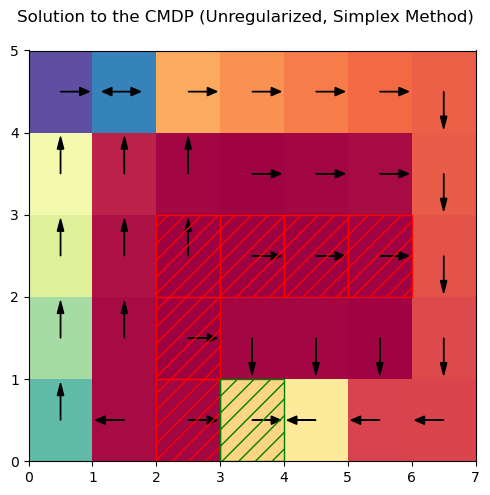

In [26]:
goals = [((3,0),2)]
obstacles = [(2,0),(3,2),(2,1),(2,2),(4,2),(5,2)]
MDP = Gridworld(7,5,0.1,0.9,goals=goals,obstacles=obstacles) #build a "wall of obstacles"
MDP.Psi = MDP.Psi*200
solver = unregCMDPLP(MDP)
mu = solver.solve()

sz = 5.

fig, ax = plt.subplots(1,1,figsize=(sz,sz))
plot = np.average(MDP.states2grid(mu),axis=2)
gridplot(MDP,ax,np.average(mu,axis=1),stochastic_policy=solver.recover_stochastic_policy(),obstacles=obstacles,goals=goals)
fig.suptitle('Solution to the CMDP (Unregularized, Simplex Method)')
fig.tight_layout()

In [15]:
mu

array([[1.00551107e-02, 0.00000000e+00, 9.69156193e-02, 0.00000000e+00],
       [4.64942072e-03, 0.00000000e+00, 6.54527941e-03, 0.00000000e+00],
       [8.33333333e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.75129858e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.78796638e-01, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 4.25020908e-03, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.02427139e-04, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 8.46740625e-02, 0.00000000e+00],
       [9.05947891e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.33333333e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.85029842e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.05583286e-02],
       [0.00000000e+00, 2.06152969e-03, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 9.72539228e-05, 0.00000000e

In [5]:
import scipy.optimize as opt
from einops import rearrange

In [6]:
E_t = rearrange(
    np.array([  np.identity(MDP.n) 
                for _ in range(MDP.m)], dtype=np.float64),
                's a n -> (s a) n').transpose()
P_t = rearrange(MDP.P_sa, 's a n -> (a s) n').transpose()
A_eq = (E_t-MDP.gamma * P_t) 
b_eq = (1-MDP.gamma) * MDP.init_distrib
A_ub = rearrange(MDP.Psi,'c a s -> (a s) c').transpose()
b_ub = MDP.b
r = rearrange(MDP.R, 's a -> (a s)')
res = opt.linprog(-r, # negative since we want to maximize
                    A_eq=A_eq, b_eq=b_eq,
                    A_ub=A_ub, b_ub=b_ub,
                    bounds=(0,None))
mu_opt = np.array([[res.x[a*MDP.n+s]
                        for a in range(MDP.m)]
                        for s in range(MDP.n)],dtype=np.float64)

In [7]:
A_ub.transpose()@r

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 100 is different from 4)

In [ ]:
A_ub.shape@r, b_ub.shape

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 100 is different from 2)

In [22]:
mu.shape

(25, 4)

In [19]:
np.max(scalar)-np.min(scalar)
(value-np.min(scalar))

array([5.10877084e-01, 3.94514563e-08, 3.94514563e-08, 3.94514563e-08])

In [16]:
scalar = mu
value = mu[0]
cmap((value-np.min(scalar))/(np.max(scalar)-np.min(scalar)))

array([[0.36862745, 0.30980392, 0.63529412, 1.        ],
       [0.61960784, 0.00392157, 0.25882353, 1.        ],
       [0.61960784, 0.00392157, 0.25882353, 1.        ],
       [0.61960784, 0.00392157, 0.25882353, 1.        ]])

In [42]:
pi

array([0, 1, 1, 1, 1, 3, 1, 1, 1, 1, 3, 3, 1, 1, 3, 3, 3, 3, 0, 1, 3, 3,
       1, 1, 0])

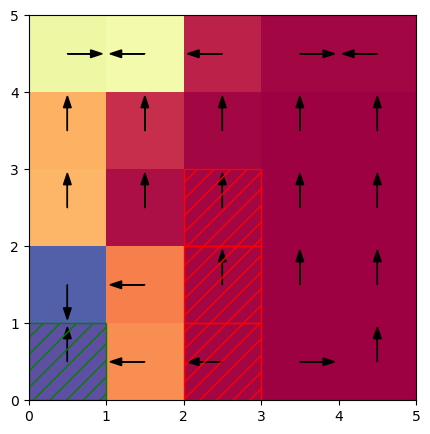

In [10]:
import matplotlib
from matplotlib.patches import Rectangle

cmap = matplotlib.cm.get_cmap('Spectral')

def gridplot(gridworld:Gridworld, ax, scalar=None, policy = None, obstacles=None, goals=None):
    ax.set_xlim([0,gridworld.grid_width])
    ax.set_ylim([0,gridworld.grid_height])
    if scalar is not None:
        for s, value in enumerate(scalar):
            ax.add_patch(Rectangle(gridworld.state2point(s),1,1,facecolor=cmap((value-np.min(scalar))/(np.max(scalar)-np.min(scalar)))))
    if policy is not None:
        for s, value in enumerate(policy):
            point = np.array(gridworld.state2point(s)) + 0.5
            arrow = np.array(gridworld.actions[value])*0.3
            ax.arrow(point[0],point[1],arrow[0],arrow[1],head_width=0.1,color='k')
    if obstacles is not None:
        for value in obstacles:
            ax.add_patch(Rectangle(value,1,1,edgecolor="r",facecolor='none',hatch='//'))
    if goals is not None:
        for value in goals:
            ax.add_patch(Rectangle(value[0],1,1,edgecolor="g",facecolor='none',hatch='//'))

obstacles = [(2,0),(2,1),(2,2)]
goals = [((0,0),2)]
MDP = Gridworld(5,5,0.1,0.9,goals=goals,obstacles=obstacles) #build a "wall of obstacles"
MDP.b = MDP.b/1000
solver = unregCMDPLP(MDP)
mu = solver.solve()
pi = solver.recover_policy()
sz = 5.
fig, ax = plt.subplots(1,1,figsize=(sz,sz))
gridplot(MDP,ax,np.log(np.sum(mu,axis=1)+0.005),pi,obstacles,goals)

# plot = np.average(MDP.states2grid(mu),axis=2)
# ax[0].matshow(np.log(plot))
# ax[0].set_title('state-occupancy measure')
# pi = solver.recover_policy()
# X = [MDP.state2point(p)[0] for p,_ in enumerate(pi)]
# Y = [MDP.state2point(p)[1] for p,_ in enumerate(pi)]
# U = [MDP.actions[a][0] for _,a in enumerate(pi)]
# V = [MDP.actions[a][1] for _,a in enumerate(pi)]
# ax[1].quiver(X,Y,U,V)
# ax[1].set_title('policy')

# fig.suptitle('solution to the CMDP')
# fig.tight_layout()

In [40]:
np.sum(mu,axis=1)

array([5.10877044e-01, 4.44248003e-01, 1.04465123e-02, 2.45797594e-04,
       5.80419067e-06, 2.16830214e-02, 1.11360676e-02, 5.00410337e-04,
       1.72725346e-05, 5.58054739e-07, 5.16088446e-04, 2.83517022e-04,
       1.87957604e-05, 8.12246696e-07, 3.15581855e-08, 1.22874986e-05,
       6.84209213e-06, 5.78017369e-07, 0.00000000e+00, 7.26403248e-10,
       2.94405763e-07, 2.08390408e-07, 5.18083135e-08, 1.19251872e-09,
       0.00000000e+00])